In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import glob
import networkx as nx

from plotnine import *
from mizani.formatters import percent_format, date_format, scientific_format
from mizani.breaks import date_breaks

data_dir = '/Users/zhicong/Dropbox/DEXs'
pool_name = 'USDC-WETH'

# Load Data

We first load the token price data.

In [2]:
price_data = pd.read_csv(os.path.join(data_dir, 'token_prices', 'WETH.csv'))
price_data['month'] = pd.to_datetime(price_data['hour']).dt.tz_localize(None).dt.to_period('M').dt.to_timestamp() 
price_volatility = price_data.groupby(['month']).agg({'price':np.std}).reset_index()

price_volatility.head()

,month,price
0,2020-05-01,11.412330
1,2020-06-01,6.667416
2,2020-07-01,36.288497
3,2020-08-01,18.249977
4,2020-09-01,31.207953


We also want to load the liquidity provision data.

In [3]:
lp_action = pd.DataFrame(columns = ['POOL_NAME', 'EVENT_NAME', 'BLOCK_NUMBER', 'BLOCK_TIMESTAMP', 'SENDER', 'NF_TOKEN_ID', 'AMOUNT0_ADJUSTED', 'TOKEN0_SYMBOL', 'AMOUNT0_USD',
                                    'AMOUNT1_ADJUSTED', 'TOKEN1_SYMBOL', 'AMOUNT1_USD', 'TICK_LOWER', 'TICK_UPPER', 'PRICE_LOWER', 'PRICE_UPPER', 'L'])

for file_name in [file for file in glob.glob(os.path.join(data_dir, "uniswapv3_lp_action_LP") + '/*.csv') if pool_name in file]:

    lp_action = pd.concat([lp_action, pd.read_csv(file_name).drop(columns = 'TX_HASH')])

# Final cleaning
lp_action['BLOCK_TIMESTAMP'] = pd.to_datetime(lp_action['BLOCK_TIMESTAMP'])
lp_action['AMOUNT0_ADJUSTED'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT0_ADJUSTED'], lp_action['AMOUNT0_ADJUSTED'])
lp_action['AMOUNT0_USD'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT0_USD'], lp_action['AMOUNT0_USD'])
lp_action['AMOUNT1_ADJUSTED'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT1_ADJUSTED'], lp_action['AMOUNT1_ADJUSTED'])
lp_action['AMOUNT1_USD'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT1_USD'], lp_action['AMOUNT1_USD'])
lp_action['L'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['L'], lp_action['L'])

# Remove observations without NF_TOKRN_ID
lp_action.dropna(subset = ['NF_TOKEN_ID'], inplace = True)
lp_action['NF_TOKEN_ID'] = lp_action['NF_TOKEN_ID'].apply(str).str.replace('.0','', regex = False)

# Round Liquidity Parameter to 5 decimal point
lp_action['L'] = round(lp_action['L'], 5)

lp_action.reset_index(drop = True, inplace = True)
lp_action.head()

,POOL_NAME,EVENT_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,NF_TOKEN_ID,AMOUNT0_ADJUSTED,TOKEN0_SYMBOL,AMOUNT0_USD,AMOUNT1_ADJUSTED,TOKEN1_SYMBOL,AMOUNT1_USD,TICK_LOWER,TICK_UPPER,PRICE_LOWER,PRICE_UPPER,L
0,USDC-WETH 3000 60,Increase Liquidity,12370624,2021-05-04 23:10:00,0x3b8ccaa89fcd432f1334d35b10ff8547001ce3e5,37,0.000000,USDC,0.000000,0.010000,WETH,33.542413,192180,193380,3999.753253,4509.682144,10.86051
1,USDC-WETH 3000 60,Increase Liquidity,12370671,2021-05-04 23:19:42,0xe14722b5f1aa6ea161e547c5ca598068ec1b3bc0,38,50000.000000,USDC,49997.486569,9.205484,WETH,30877.415059,192660,199800,2104.893286,4298.340735,4303.36967
2,USDC-WETH 3000 60,Increase Liquidity,12371434,2021-05-05 02:10:21,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,41,167.505955,USDC,167.501413,0.044750,WETH,150.584382,195060,195540,3222.777198,3381.235151,229.98572
3,USDC-WETH 3000 60,Increase Liquidity,12371483,2021-05-05 02:21:03,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,41,0.010000,USDC,0.010000,0.000003,WETH,0.008990,195060,195540,3222.777198,3381.235151,0.01373
4,USDC-WETH 3000 60,Decrease Liquidity,12371521,2021-05-05 02:30:25,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,41,-167.515954,USDC,-167.511412,-0.044752,WETH,-150.593372,195060,195540,3222.777198,3381.235151,-229.99945


For the same token, we want to change them to the same address (the mint recepient address).

In [4]:
address_cluster = lp_action[['POOL_NAME','NF_TOKEN_ID','SENDER']].copy()
address_cluster['unique_address'] = address_cluster.groupby(['POOL_NAME','NF_TOKEN_ID'])['SENDER'].transform('nunique')
address_cluster = address_cluster[address_cluster['unique_address'] > 1]
address_cluster.drop_duplicates(inplace = True)

address_cluster = address_cluster.groupby(['POOL_NAME','NF_TOKEN_ID'])['SENDER'].apply(list).reset_index()
address_cluster = address_cluster['SENDER']

# Concat lists if they share common element
G = nx.Graph()
for l in address_cluster:
    G.add_edges_from(nx.utils.pairwise(l))
connected_components = list(nx.connected_components(G))
address_cluster = pd.DataFrame({'SENDER':[list(comp) for comp in connected_components]})

# Take one address as the shared address for all lists
address_cluster['ADDRESS'] = address_cluster['SENDER'].str[0]
address_cluster = address_cluster.explode('SENDER', ignore_index = True)
address_cluster = address_cluster[['ADDRESS','SENDER']].set_index('SENDER').to_dict()['ADDRESS']

lp_action['SENDER'] = lp_action['SENDER'].replace(address_cluster)

# Identifying liquidity reallocation 

Since liquidity allocation depends on risk-aversion of the liquidity provider, we want to identify events of liquidity reallocation which can signal when a liquidity provider changes their risk aversion.

## Across multiple fee pools

First, we filter for LP actions of LPs that have provided liquidity in multiple pools.

In [5]:
multi_pool_LPs = lp_action.groupby(['SENDER'])['POOL_NAME'].nunique().reset_index()
multi_pool_LPs = multi_pool_LPs[multi_pool_LPs['POOL_NAME'] >= 2]['SENDER']

multi_pool_lp_action = lp_action[lp_action['SENDER'].isin(multi_pool_LPs)]
multi_pool_lp_action = multi_pool_lp_action.sort_values(by = ['SENDER','BLOCK_NUMBER','POOL_NAME'])
multi_pool_lp_action.reset_index(drop = True, inplace = True)

multi_pool_LPs.head()

1     0x00000000002108f4085d2fd429669ce8f9851241
7     0x0000c3caa36e2d9a8cd5269c976ede05018f0000
18    0x0008d343091ef8bd3efa730f6aae5a26a285c7a2
20    0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d
24    0x000ef2b60d565ac16d06ff791129055e591b631e
Name: SENDER, dtype: object

We define LP reallocation across pools based on multiple conditions:

- The same address withdrew liquidity in one pool then provided liquidity in another pool of different fees.

- The two action is done within 1 day.

In [6]:
multi_pool_lp_action['time_diff'] = multi_pool_lp_action.groupby(['SENDER'])['BLOCK_TIMESTAMP'].diff()

liquidity_reallocation = pd.DataFrame()

for i in range(len(multi_pool_lp_action)-1):
    
    if (multi_pool_lp_action.loc[i,'EVENT_NAME'] == 'Decrease Liquidity') & (multi_pool_lp_action.loc[i+1,'EVENT_NAME'] == 'Increase Liquidity') &\
       (multi_pool_lp_action.loc[i,'POOL_NAME'] != multi_pool_lp_action.loc[i+1,'POOL_NAME']) &\
       (multi_pool_lp_action.loc[i+1,'time_diff'] <= dt.timedelta(days = 1)):

        new_row = {'SENDER':multi_pool_lp_action.loc[i,'SENDER'], 
                   'Decreased Liquidity Pool':multi_pool_lp_action.loc[i,'POOL_NAME'], 
                   'Decreased Liquidity Block Number':multi_pool_lp_action.loc[i,'BLOCK_NUMBER'], 'Decreased Liquidity Timestamp':multi_pool_lp_action.loc[i,'BLOCK_TIMESTAMP'],
                   'Decreased Liquidity Token0 Amount':multi_pool_lp_action.loc[i,'AMOUNT0_ADJUSTED'], 'Decreased Liquidity Token1 Amount':multi_pool_lp_action.loc[i,'AMOUNT1_ADJUSTED'],
                   'Decreased Liquidity Token0 USD':multi_pool_lp_action.loc[i,'AMOUNT0_USD'], 'Decreased Liquidity Token1 USD':multi_pool_lp_action.loc[i,'AMOUNT1_USD'],
                   'Decreased Liquidity Price Lower':multi_pool_lp_action.loc[i,'PRICE_LOWER'], 'Decreased Liquidity Price Upper':multi_pool_lp_action.loc[i,'PRICE_UPPER'],
                   'Increased Liquidity Pool':multi_pool_lp_action.loc[i+1,'POOL_NAME'], 
                   'Increased Liquidity Block Number':multi_pool_lp_action.loc[i+1,'BLOCK_NUMBER'], 'Increased Liquidity Timestamp':multi_pool_lp_action.loc[i+1,'BLOCK_TIMESTAMP'],
                   'Increased Liquidity Token0 Amount':multi_pool_lp_action.loc[i+1,'AMOUNT0_ADJUSTED'], 'Increased Liquidity Token1 Amount':multi_pool_lp_action.loc[i+1,'AMOUNT1_ADJUSTED'],
                   'Increased Liquidity Token0 USD':multi_pool_lp_action.loc[i+1,'AMOUNT0_USD'], 'Increased Liquidity Token1 USD':multi_pool_lp_action.loc[i+1,'AMOUNT1_USD'],
                   'Increased Liquidity Price Lower':multi_pool_lp_action.loc[i+1,'PRICE_LOWER'], 'Increased Liquidity Price Upper':multi_pool_lp_action.loc[i+1,'PRICE_UPPER']}
        
        
        liquidity_reallocation = pd.concat([liquidity_reallocation, pd.DataFrame([new_row])], ignore_index = True)

liquidity_reallocation['month'] = pd.to_datetime(liquidity_reallocation['Decreased Liquidity Timestamp']).dt.to_period('M').dt.to_timestamp()

liquidity_reallocation.head(5)

,SENDER,Decreased Liquidity Pool,Decreased Liquidity Block Number,Decreased Liquidity Timestamp,Decreased Liquidity Token0 Amount,Decreased Liquidity Token1 Amount,Decreased Liquidity Token0 USD,Decreased Liquidity Token1 USD,Decreased Liquidity Price Lower,Decreased Liquidity Price Upper,Increased Liquidity Pool,Increased Liquidity Block Number,Increased Liquidity Timestamp,Increased Liquidity Token0 Amount,Increased Liquidity Token1 Amount,Increased Liquidity Token0 USD,Increased Liquidity Token1 USD,Increased Liquidity Price Lower,Increased Liquidity Price Upper,month
0,0x00000000002108f4085d2fd429669ce8f9851241,USDC-WETH 3000 60,15518186,2022-09-12 01:37:06,-73.064052,-13.205754,-72.964100,-22955.694907,1747.653568,3999.753253,USDC-WETH 500 10,15518422,2022-09-12 02:32:53,0.000000,13.205776,0.000000,23048.833358,1770.520232,3999.753253,2022-09-01
1,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,USDC-WETH 500 10,15619810,2022-09-26 20:05:47,-12476.856493,-0.000000,-12476.856493,-0.000000,1280.549930,1320.866643,USDC-WETH 3000 60,15619838,2022-09-26 20:11:23,3001.700320,7.232869,3001.700320,9607.998411,1326.160425,1342.169412,2022-09-01
2,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,USDC-WETH 500 10,15826365,2022-10-25 16:43:59,-15134.375588,-0.000000,-15134.375588,-0.000000,1299.901989,1399.738130,USDC-WETH 3000 60,15826390,2022-10-25 16:48:59,5350.002794,6.901477,5350.002794,9733.222714,1391.365263,1451.044104,2022-10-01
3,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,USDC-WETH 3000 60,15412421,2022-08-26 01:13:28,-1370.879891,-1.222358,-1370.879891,-2057.582246,1550.038965,1889.420503,USDC-WETH 500 10,15412454,2022-08-26 01:21:03,1374.544513,1.224162,1374.544513,2060.619532,1553.141990,1898.890788,2022-08-01
4,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,USDC-WETH 3000 60,15732063,2022-10-12 12:34:35,-759.045718,-1.935490,-758.969054,-2515.846212,1234.037691,1504.230647,USDC-WETH 500 10,15735330,2022-10-12 23:31:59,816.655329,1.859767,816.545897,2410.685574,1270.346907,1372.022830,2022-10-01


### By Number of Action

We are interested if there is a certain time period where many liquidity providers change their liquidity position.

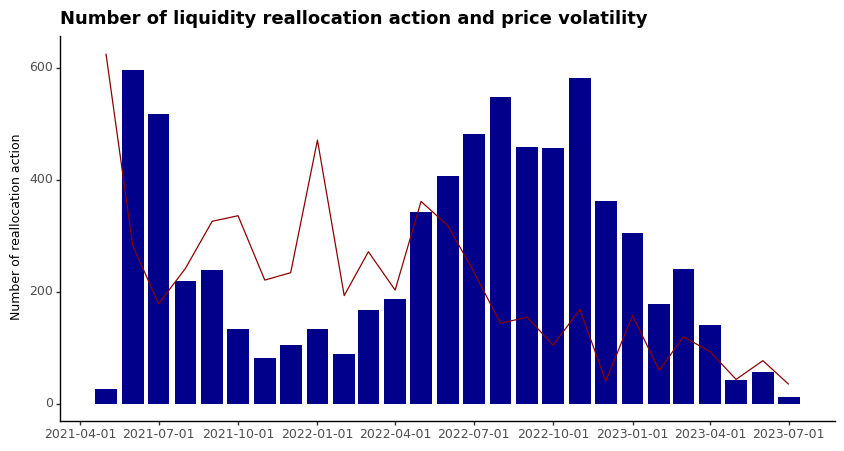

In [7]:
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month'])['SENDER'].count().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'SENDER'), fill = 'darkblue') + 
    geom_line(aes(y = 'price'), color = 'darkred') +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Number of liquidity reallocation action and price volatility',
         x = '', y = 'Number of reallocation action')
)

#fig.save('./Plots/Number of liquidity reallocation action and price volatility', dpi = 1000)

print(fig)

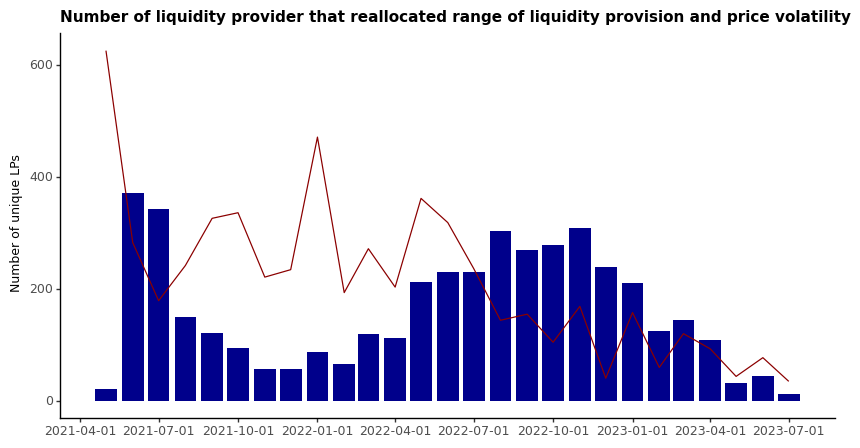

In [8]:
liquidity_reallocation_LP_by_month = liquidity_reallocation.groupby(['month'])['SENDER'].nunique().reset_index()
liquidity_reallocation_LP_by_month = liquidity_reallocation_LP_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_LP_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'SENDER'), fill = 'darkblue') + 
    geom_line(aes(y = 'price'), color = 'darkred') +
    
    theme_classic() +
    theme(plot_title = element_text(size = 11, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Number of liquidity provider that reallocated range of liquidity provision and price volatility',
         x = '', y = 'Number of unique LPs')
)

#fig.save('./Plots/Number of unique liquidity provider that reallocated range of liquidity provision and price volatility.png', dpi = 1000)

print(fig)

It is very interesting to see that the time of peak liquidity reallocation is during November 2022, which is the same month of the FTX collaspe.

Next, we want to seperate liquidity reallocation to 2 different situations:

- When liquidity provision moves from lower fees pool to higher fees pool

- When liquidity provision moves from higher fees pool to lower fees pool

In [9]:
liquidity_reallocation['Reallocation Action'] = np.where(((liquidity_reallocation['Decreased Liquidity Pool'] == 'USDC-WETH 3000 60') & (liquidity_reallocation['Increased Liquidity Pool'] == 'USDC-WETH 500 10')) |\
                                                         ((liquidity_reallocation['Decreased Liquidity Pool'] == 'USDC-WETH 500 10') & (liquidity_reallocation['Increased Liquidity Pool'] == 'USDC-WETH 100 1')),
                                                         'Increasing Fee Pool', 'Decreasing Fee Pool')

liquidity_reallocation[['SENDER','month','Reallocation Action']].head()

,SENDER,month,Reallocation Action
0,0x00000000002108f4085d2fd429669ce8f9851241,2022-09-01,Increasing Fee Pool
1,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-09-01,Decreasing Fee Pool
2,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-10-01,Decreasing Fee Pool
3,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,2022-08-01,Increasing Fee Pool
4,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,2022-10-01,Increasing Fee Pool


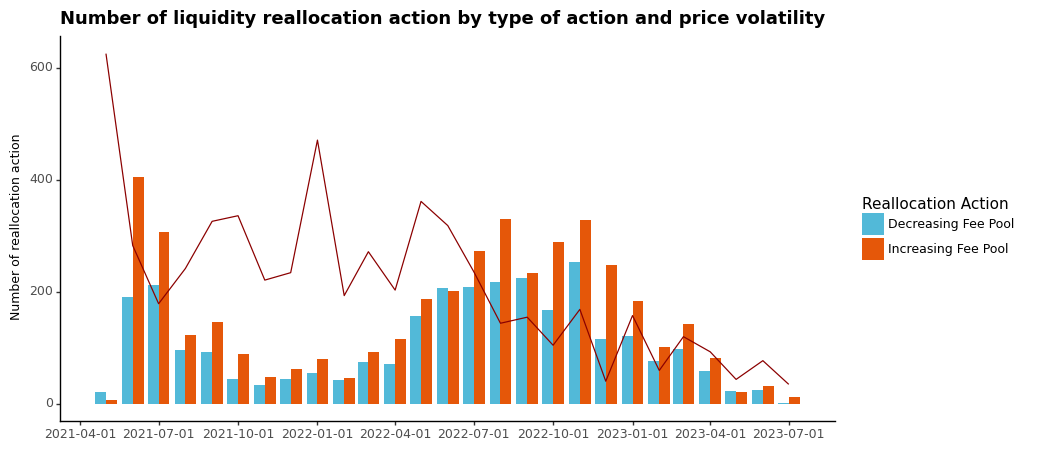

In [10]:
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month','Reallocation Action'])['SENDER'].count().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'SENDER', fill = 'Reallocation Action'), position = 'dodge') + 
    geom_line(aes(y = 'price'), color = 'darkred') +

    scale_fill_manual(values = ['#52b9d8','#e55709']) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5),
          legend_text = element_text(size = 9)) +
    labs(title = 'Number of liquidity reallocation action by type of action and price volatility',
         x = '', y = 'Number of reallocation action')
)

#fig.save('./Plots/Number of liquidity reallocation action by type of action and price volatility', dpi = 1000)

print(fig)

### By Volume in USD

Since liquidity providers might not provide the same amount of token they withdrew into the pool again, we take the average of the two values as mean volume.

In [11]:
liquidity_reallocation['USD_mean'] = (np.abs(liquidity_reallocation[['Decreased Liquidity Token0 USD','Decreased Liquidity Token1 USD']].sum(axis = 1)) +\
                                      liquidity_reallocation[['Increased Liquidity Token0 USD','Increased Liquidity Token1 USD']].sum(axis = 1))/2

liquidity_reallocation[['SENDER','month','USD_mean']].head()

,SENDER,month,USD_mean
0,0x00000000002108f4085d2fd429669ce8f9851241,2022-09-01,23038.746183
1,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-09-01,12543.277612
2,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-10-01,15108.800548
3,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,2022-08-01,3431.813091
4,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,2022-10-01,3251.023369


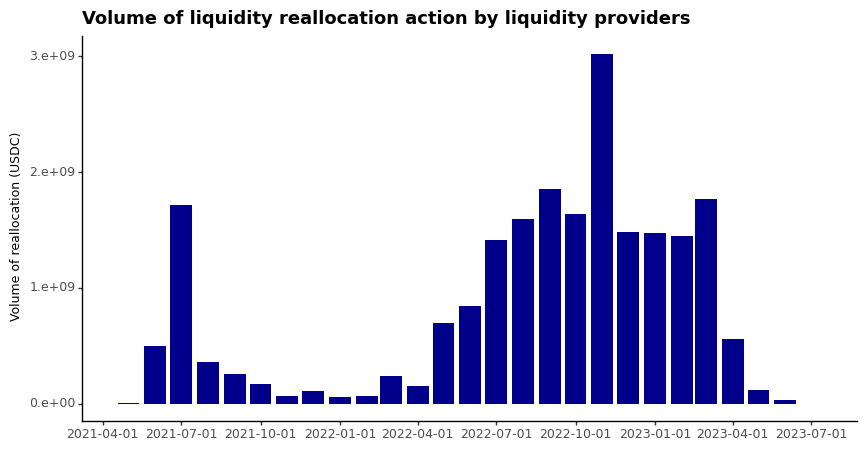

In [12]:
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month'])['USD_mean'].sum().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'USD_mean'), fill = 'darkblue') + 

    scale_y_continuous(labels = scientific_format(digits = 2)) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Volume of liquidity reallocation action by liquidity providers',
         x = '', y = 'Volume of reallocation (USDC)')
)

#fig.save('./Plots/Volume of liquidity reallocation action', dpi = 1000)

print(fig)

We can see that by volume, the reallocation volume is even stronger in November 2022, the month of the collaspe of FTX.

With volume, we also want to explore the volume of decreasing/increasing pool fees.

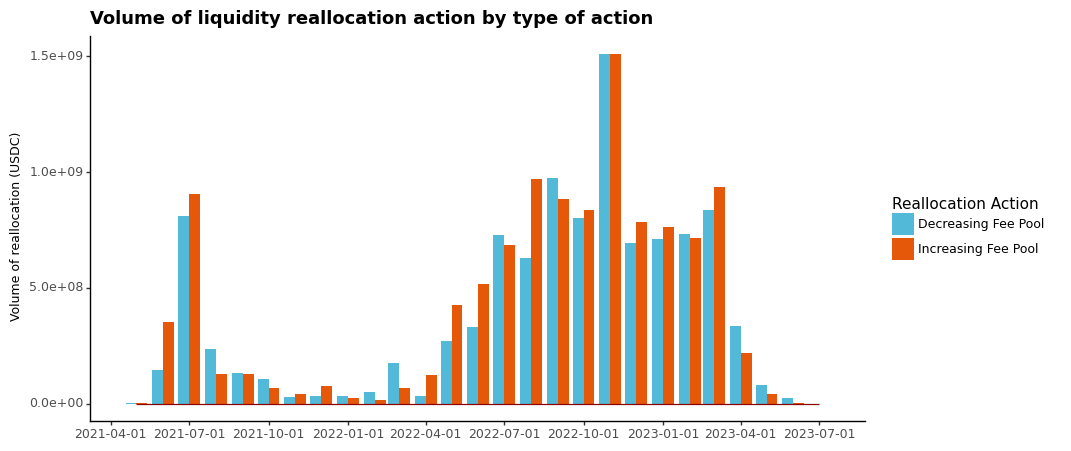

In [13]:
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month','Reallocation Action'])['USD_mean'].sum().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'USD_mean', fill = 'Reallocation Action'), position = 'dodge') + 
    geom_line(aes(y = 'price'), color = 'darkred') +

    scale_y_continuous(labels = scientific_format(digits = 2)) +
    scale_fill_manual(values = ['#52b9d8','#e55709']) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5),
          legend_text = element_text(size = 9)) +
    labs(title = 'Volume of liquidity reallocation action by type of action',
         x = '', y = 'Volume of reallocation (USDC)')
)

#fig.save('./Plots/Volume of liquidity reallocation action by type of action', dpi = 1000)

print(fig)

It is surprising that volume of LP increasing pool fees is similar to volume of decreasing pool fees in November 2022. We will split these into seperate cases during analysis.

### By Day

We also want to look close to by day of November 2022 to see exactly what happened.

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Number of liquidity provider that reallocated range of liquidity provision in Nov 2022


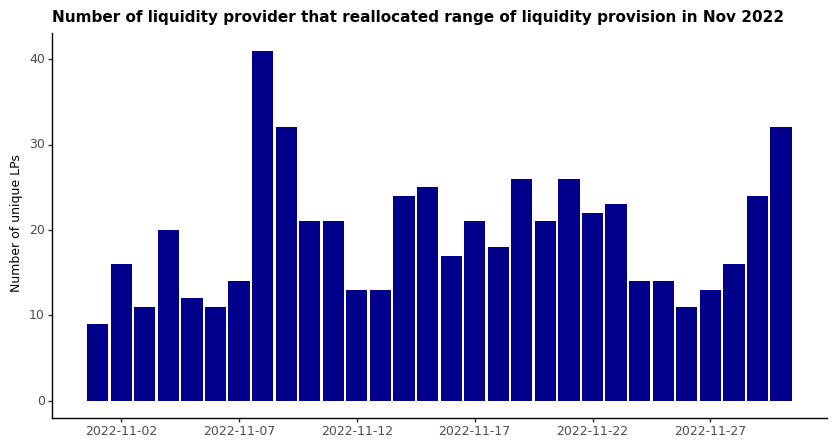

In [30]:
liquidity_reallocation_nov2022 = liquidity_reallocation[(liquidity_reallocation['Decreased Liquidity Timestamp'] >= dt.datetime(2022,11,1)) &\
                                                        (liquidity_reallocation['Increased Liquidity Timestamp'] < dt.datetime(2022,12,1))].copy()
liquidity_reallocation_nov2022['date'] = liquidity_reallocation_nov2022['Decreased Liquidity Timestamp'].dt.date
liquidity_reallocation_nov2022 = liquidity_reallocation_nov2022.groupby(['date'])['SENDER'].count().reset_index()

fig = (
ggplot(liquidity_reallocation_nov2022, aes(x = 'date')) + 
    geom_col(aes(y = 'SENDER'), fill = 'darkblue') + 

    scale_x_datetime(breaks = date_breaks('5 days')) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 11, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Number of liquidity provider that reallocated range of liquidity provision in Nov 2022',
         x = '', y = 'Number of unique LPs')
)

fig.save('./Plots/Number of liquidity provider that reallocated range of liquidity provision in Nov 2022', dpi = 1000)

print(fig)

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Volume of liquidity reallocation action by type of action in Nov 2022


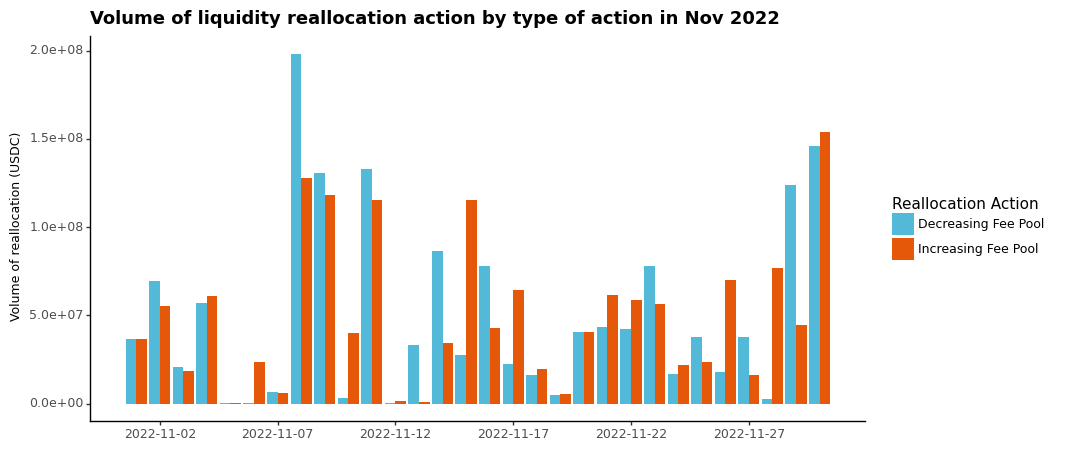

In [31]:
liquidity_reallocation_nov2022 = liquidity_reallocation[(liquidity_reallocation['Decreased Liquidity Timestamp'] >= dt.datetime(2022,11,1)) &\
                                                        (liquidity_reallocation['Increased Liquidity Timestamp'] < dt.datetime(2022,12,1))].copy()
liquidity_reallocation_nov2022['date'] = liquidity_reallocation_nov2022['Decreased Liquidity Timestamp'].dt.date
liquidity_reallocation_nov2022 = liquidity_reallocation_nov2022.groupby(['date','Reallocation Action'])['USD_mean'].sum().reset_index()

fig = (
ggplot(liquidity_reallocation_nov2022, aes(x = 'date')) + 
    geom_col(aes(y = 'USD_mean', fill = 'Reallocation Action'), position = 'dodge') + 

    scale_x_datetime(breaks = date_breaks('5 days')) +
    scale_y_continuous(labels = scientific_format(digits = 2)) +
    scale_fill_manual(values = ['#52b9d8','#e55709']) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5),
          legend_text = element_text(size = 9)) +
    labs(title = 'Volume of liquidity reallocation action by type of action in Nov 2022',
         x = '', y = 'Volume of reallocation (USDC)')
)

fig.save('./Plots/Volume of liquidity reallocation action by type of action in Nov 2022', dpi = 1000)

print(fig)

The situation on 8 November is just as we expect, with the fall in price FTX Token inducing huge loss to FTX Token holders, many LPs choose to decrease their fee pool and supply within a pool with lower fees.

### Decreased pool fees LP

We use this section to investigate the LPs that chose to decrease pool fees